## SHAP Feature Importance Aggregation Across Models

This notebook analyzes and visualizes feature importance across different models using aggregated SHAP values.

### 1. Input Data
- CSV file with repeated column pairs: `[Feature, SHAP value]` per model.
- CSVs to combine different IG values from different models to one model

### 2. Data Transformation
- `reshape_shap_csv()`: reshapes data to long format with columns:
  - `Model`, `Feature`, `SHAP`, `Rank` (1 = most important).
- `reshape_shap_csv_reversed()`: assigns reversed ranks for visualization contrast.
- same goes for Integrated Gradients.

### 3. Mean Ranking
- `compute_mean_ranks()`: computes per-feature mean and std of:
  - SHAP values / IG Values
  - Feature ranks of SHAP and IG
- Output is sorted by mean rank (descending importance).

### 4. Visualizations
- `plot_rank_heatmap()`: rank heatmap across models.
- `plot_shap_mean_std_barplot()`: mean ± std of SHAP / IG values per feature.
- `plot_feature_rank_barplot()`: mean ± std of feature ranks across models.

### Goal
Identify features that are consistently important across ML architectures.


In [8]:
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

paths_by_model = {
    "CNN": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/cnn/1103_175837/ig_map_cnn.csv",
    "GRU": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/gru/0721_162240/ig_map_gru.csv",
    "GTN": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/gtn/0721_171303/ig_map_gtn.csv",
    "LSTM": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/lstm/0721_155144/ig_map_lstm.csv",
    "MLP": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/mlp/0721_155014/ig_map_mlp.csv",
    "TFT": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/tft/0721_164730/ig_map_tft.csv",
    "Transformer": "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/ml_tracks/a_fire_danger/saved/ig-plots/transformer/0721_155850/ig_map_transformer.csv",
}

ignore_cols = ["sample", "label", "x", "y", "probs"]

out_dir = Path("/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/ig_map_csv")
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / "ig_map_ranked_mean_abs.csv"

def mean_abs_ig_per_feature(csv_path: str, ignore=ignore_cols) -> pd.Series:
    """Return a Series: index=feature name, values=mean(|IG|), sorted desc."""
    df = pd.read_csv(csv_path)
    feature_cols = [c for c in df.columns if c not in ignore]
    vals = df[feature_cols].apply(pd.to_numeric, errors="coerce").abs().mean(axis=0)
    vals = vals.fillna(0.0).sort_values(ascending=False)
    return vals

rank_tables = {}
n_features_expected = None

for model, path in paths_by_model.items():
    s = mean_abs_ig_per_feature(path)
    if n_features_expected is None:
        n_features_expected = len(s)
    else:
        if len(s) != n_features_expected:
            print(f"Warning: {model} has {len(s)} features; expected {n_features_expected}.")
    # Create a two-column DataFrame: Feature, Value
    df_model = pd.DataFrame({
        model: s.index.to_list(),
        f"{model} Values": s.values
    })
    rank_tables[model] = df_model


combined = pd.DataFrame(index=range(max(len(df) for df in rank_tables.values())))
for model in paths_by_model.keys():
    dfm = rank_tables[model].reset_index(drop=True)
    combined = pd.concat([combined, dfm], axis=1)


combined.to_csv(out_csv, index=False)
print(f"Saved combined IG ranking CSV to:\n{out_csv}")

combined.head(10)

Saved combined IG ranking CSV to:
/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/ig_map_csv/ig_map_ranked_mean_abs.csv


,CNN,CNN Values,GRU,GRU Values,GTN,GTN Values,LSTM,LSTM Values,MLP,MLP Values,TFT,TFT Values,Transformer,Transformer Values
0,lst_day,0.025349,lst_day,0.172980,lst_day,0.042621,lst_day,0.157440,lst_day,0.035198,dem,0.270806,lst_day,0.042056
1,tp,0.015343,tp,0.116100,tp,0.018999,tp,0.099897,tp,0.022404,slope,0.162069,tp,0.017520
2,ssrd,0.014611,rh,0.085662,rh,0.016405,rh,0.084832,ndvi,0.017934,lc_shrubland,0.127233,rh,0.014117
3,wind_speed,0.013504,ndvi,0.077941,ndvi,0.011376,ndvi,0.066784,ssrd,0.015844,lc_grassland,0.105200,ssrd,0.013455
4,ndvi,0.013294,d2m,0.067216,smi,0.011280,ssrd,0.062615,rh,0.015598,lc_agriculture,0.079802,wind_speed,0.012440
5,rh,0.011095,dem,0.065521,dem,0.010994,lc_agriculture,0.060514,sp,0.015057,population,0.075554,lst_night,0.012312
6,lst_night,0.010893,ssrd,0.063259,d2m,0.010563,lc_forest,0.059916,dem,0.012319,lc_forest,0.073744,ndvi,0.012144
7,sp,0.010514,sp,0.059691,wind_speed,0.010351,sp,0.058667,lst_night,0.012120,roads_distance,0.056563,t2m,0.009835
8,t2m,0.010128,lst_night,0.053176,ssrd,0.010143,d2m,0.057295,wind_speed,0.010709,lc_sparse_vegetation,0.047414,sp,0.008969
9,smi,0.008169,lc_forest,0.050331,sp,0.008729,t2m,0.054256,lc_agriculture,0.010336,lst_day,0.036014,dem,0.008931


In [10]:
def sum_abs_feature_columns(csv_path: str):
    df = pd.read_csv(csv_path)

    exclude_cols = {"sample", "label", "x", "y"}
    feature_cols = [c for c in df.columns if c not in exclude_cols]

    abs_sums = df[feature_cols].abs().sum(axis=0)   # sum per column
    return abs_sums.sort_values(ascending=False)    # optional: sorted

csv_path = "/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/ig_map_csv/shap_map_xgb.csv"
abs_sums = sum_abs_feature_columns(csv_path)

print(abs_sums)

tp                      103.158953
t2m                      90.088212
lst_day                  81.726236
rh                       78.021682
d2m                      67.083827
ndvi                     54.181310
smi                      50.536884
wind_speed               42.638338
slope                    41.891110
ssrd                     34.435304
lst_night                20.592423
population               17.786012
sp                       16.214898
lc_grassland             15.900482
lc_shrubland             13.760223
lc_agriculture           13.024477
lai                       9.911541
dem                       9.156719
lc_forest                 6.994126
lc_sparse_vegetation      6.377118
roads_distance            6.004609
lc_wetland                2.175010
lc_water_bodies           0.273660
lc_settlement             0.058997
dtype: float64


In [27]:
import pandas as pd

def reorder_model_pairs(df: pd.DataFrame, model_order):
    """
    Reorder columns in df assuming pairs like:
      Model, Model Values
    Handles extra whitespace (e.g., " XGB", "LSTM ", etc.).
    """
    # 1) normalize column names (strip spaces)
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    cols = list(df.columns)

    # 2) build mapping: base_model -> (model_col, values_col)
    pairs = {}
    colset = set(cols)

    for c in cols:
        if c.endswith(" Values"):
            continue
        base = c.strip()
        values_col = f"{base} Values"
        if values_col in colset:
            pairs[base] = (base, values_col)

    # 3) create reordered list (pairs stay together)
    new_cols = []
    missing = [m for m in model_order if m not in pairs]
    if missing:
        raise KeyError(f"Missing model pairs for: {missing}. Available: {sorted(pairs.keys())}")

    for m in model_order:
        new_cols.extend(pairs[m])

    return df[new_cols]

order = ["CNN", "GRU", "GTN", "LSTM", "MLP", "Transformer", "TFT", "RF", "XGB"]
df = pd.read_csv("/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/Shap_Importance_across_Models.csv", sep=";")
df_reordered = reorder_model_pairs(df, order)
df_reordered

,CNN,CNN Values,GRU,GRU Values,GTN,GTN Values,LSTM,LSTM Values,MLP,MLP Values,Transformer,Transformer Values,TFT,TFT Values,RF,RF Values,XGB,XGB Values
0,lst_day,485.733630,lst_day,485.733630,lst_day,403.062560,lst_day,497.684577,lst_day,439.223965,lst_day,324.343303,lst_day,421.400033,lst_night,285.830591,tp,103.158953
1,rh,234.213224,tp,234.213224,rh,253.561110,tp,256.260265,tp,249.558440,rh,233.165776,rh,220.110369,t2m,268.531340,t2m,90.088212
2,t2m,213.863433,rh,213.863433,tp,197.841731,rh,245.656470,rh,239.078391,wind_speed,181.979280,slope,145.410271,smi,186.757731,lst_day,81.726236
3,smi,210.441579,t2m,210.441579,ndvi,196.649515,t2m,223.963758,ndvi,184.116310,t2m,171.131882,tp,145.381731,slope,163.107668,rh,78.021682
4,ndvi,169.992447,d2m,169.992447,t2m,150.178739,d2m,183.504959,t2m,147.972623,d2m,167.505315,dem,144.763325,lst_day,145.644826,d2m,67.083827
5,sp,162.943874,sp,162.943874,d2m,146.202072,sp,152.223518,wind_speed,142.926393,ndvi,165.414351,t2m,140.409678,ndvi,144.934797,ndvi,54.181310
6,tp,153.653144,dem,153.653144,wind_speed,124.669604,dem,144.187706,sp,137.188546,tp,139.258212,ndvi,120.598855,d2m,127.884915,smi,50.536884
7,ssrd,138.265346,lc_agriculture,138.265346,sp,119.805600,lc_agriculture,140.066920,ssrd,136.582593,lst_night,127.226599,wind_speed,116.991155,ssrd,106.720006,wind_speed,42.638338
8,wind_speed,129.157395,ndvi,129.157395,ssrd,104.957210,ndvi,139.621618,d2m,133.410565,ssrd,126.297051,lst_night,93.896139,tp,96.092213,slope,41.891110
9,dem,111.586594,wind_speed,111.586594,lst_night,94.659856,wind_speed,136.114157,lst_night,118.949333,sp,114.922303,lc_shrubland,91.745909,rh,85.579563,ssrd,34.435304


In [11]:
df = pd.read_csv("/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/Shap_Importance_across_Models.csv", sep=";")
df_ig = pd.read_csv("/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/ig_map_csv/ig_map_ranked_mean_abs.csv", sep=",")
def reshape_shap_csv(df: pd.DataFrame):
    records = []
    for i in range(0, df.shape[1], 2):
        model_name = df.columns[i]
        shap_column = df.columns[i+1]
        features = df[model_name]
        shap_values = df[shap_column]

        #max_rank = len(features)
        for rank, (feature, shap_value) in enumerate(zip(features, shap_values), 1):
            #reversed_rank = max_rank - rank + 1
            records.append({
                "Model": model_name,
                "Feature": feature,
                "SHAP": shap_value,
                "Rank": rank
            })

    return pd.DataFrame(records)
df_ordered = reshape_shap_csv(df)
df_ig_ordered = reshape_shap_csv(df_ig)

def reshape_shap_csv_reveresed(df: pd.DataFrame):
    records = []
    for i in range(0, df.shape[1], 2):
        model_name = df.columns[i]
        shap_column = df.columns[i+1]
        features = df[model_name]
        shap_values = df[shap_column]

        max_rank = len(features)
        for rank, (feature, shap_value) in enumerate(zip(features, shap_values), 1):
            reversed_rank = max_rank - rank + 1
            records.append({
                "Model": model_name,
                "Feature": feature,
                "SHAP": shap_value,
                "Rank": reversed_rank
            })

    return pd.DataFrame(records)
df_ordered = reshape_shap_csv(df)
df_reversed = reshape_shap_csv_reveresed(df)
df_ig_reversed = reshape_shap_csv_reveresed(df_ig)
df_ordered

,Model,Feature,SHAP,Rank
0,Transformer,lst_day,324.343303,1
1,Transformer,rh,233.165776,2
2,Transformer,wind_speed,181.979280,3
3,Transformer,t2m,171.131882,4
4,Transformer,d2m,167.505315,5
...,...,...,...,...
211,XGB,lc_sparse_vegetation,6.377118,20
212,XGB,roads_distance,6.004609,21
213,XGB,lc_wetland,2.175010,22
214,XGB,lc_water_bodies,0.273660,23


In [29]:
df_reversed_shap = reshape_shap_csv_reveresed(df_reordered)
df_reversed_shap

,Model,Feature,SHAP,Rank
0,CNN,lst_day,485.733630,24
1,CNN,rh,234.213224,23
2,CNN,t2m,213.863433,22
3,CNN,smi,210.441579,21
4,CNN,ndvi,169.992447,20
...,...,...,...,...
211,XGB,lc_sparse_vegetation,6.377118,5
212,XGB,roads_distance,6.004609,4
213,XGB,lc_wetland,2.175010,3
214,XGB,lc_water_bodies,0.273660,2


In [17]:
def compute_mean_ranks1(df: pd.DataFrame, output_path: str = "mean_ranks.csv"):
    mean_ranks = df.groupby('Feature')['Rank'].agg(['mean', 'std']).reset_index()
    mean_ranks.columns = ['Feature', 'MeanRank', 'StdRank']
    mean_ranks.sort_values("MeanRank", inplace=True)
    mean_ranks.to_csv(output_path, index=False)
    return mean_ranks

def compute_mean_ranks(df: pd.DataFrame, output_path: str = "mean_ranks.csv"):
    grouped = df.groupby('Feature').agg(
        MeanRank=('Rank', 'mean'),
        StdRank=('Rank', 'std'),
        MeanSHAP=('SHAP', 'mean'),
        StdSHAP=('SHAP', 'std')
    ).reset_index()

    grouped.sort_values("MeanRank", ascending=False, inplace=True)
    grouped.to_csv(output_path, index=False)
    return grouped


def plot_rank_heatmap(df: pd.DataFrame, xai_method):
    pivot = df.pivot(index='Model', columns='Feature', values='Rank')

    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(pivot, annot=False, cmap="RdBu_r", cbar=False, ax=ax)

    norm = plt.Normalize(vmin=pivot.min().min(), vmax=pivot.max().max())
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_ticks([pivot.min().min(), pivot.max().max()])
    cbar.set_ticklabels(["Low\nImportance", "High\nImportance"])
    cbar.ax.tick_params(labelsize=16)
    

    ax.set_title("")
    ax.set_ylabel("Models", fontsize=16, fontweight='medium')
    ax.set_xlabel("Features", fontsize=16, fontweight='medium')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14, fontweight='medium')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=14, fontweight='medium')

    plt.tight_layout()
    plt.savefig(f'/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Paper Revision/rank_heatmap_{xai_method}.png', format='png', dpi=300)
    plt.show()


In [45]:
compute_mean_ranks(df_ig_ordered, output_path="/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/ig_map_csv/mean_ranks_ig.csv")

,Feature,MeanRank,StdRank,MeanSHAP,StdSHAP
9,lc_water_bodies,22.857143,2.609506,0.002355,0.003603
6,lc_settlement,21.142857,3.625308,0.003323,0.004274
10,lc_wetland,21.000000,4.472136,0.006334,0.011499
2,lai,19.285714,2.138090,0.006982,0.006678
14,population,18.714286,5.618846,0.014420,0.027147
8,lc_sparse_vegetation,18.428571,4.197505,0.011475,0.016480
5,lc_grassland,15.428571,5.159365,0.022020,0.037125
16,roads_distance,15.142857,3.436499,0.015716,0.019155
7,lc_shrubland,14.142857,5.304984,0.028200,0.044912
18,smi,12.571429,4.157609,0.016242,0.013510


In [48]:
compute_mean_ranks(df_ordered, output_path="/Users/paulinebecker/Desktop/mesogeos_git/mesogeos/csv/mean_ranks.csv")

,Feature,MeanRank,StdRank,MeanSHAP,StdSHAP
9,lc_water_bodies,23.500,0.925820,20.302502,24.157203
6,lc_settlement,22.625,0.916125,44.335659,17.543927
10,lc_wetland,22.000,1.511858,34.385885,24.252138
8,lc_sparse_vegetation,20.375,1.302470,49.337076,16.758143
14,population,20.000,3.741657,55.691070,6.764080
16,roads_distance,17.500,1.772811,59.235658,18.843830
5,lc_grassland,17.375,1.846812,58.979176,12.795440
4,lc_forest,16.125,2.850439,67.418281,16.066825
2,lai,16.000,1.603567,64.026397,12.208162
3,lc_agriculture,14.625,4.274091,79.385358,39.383708


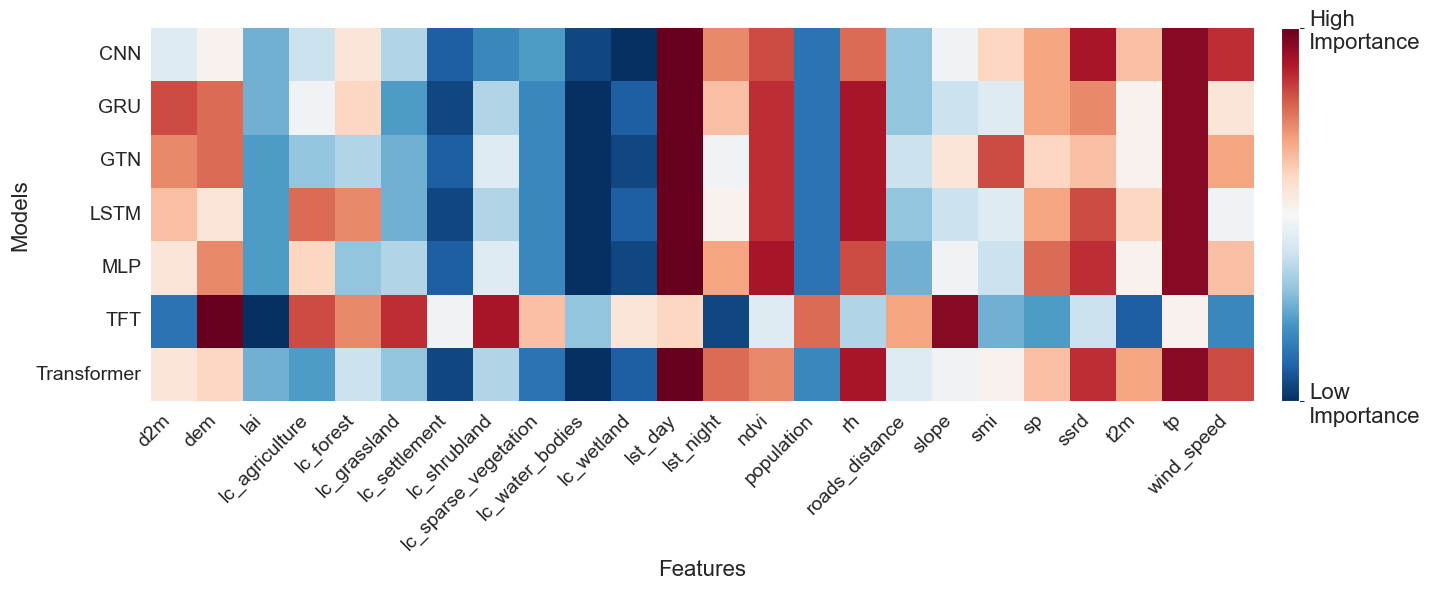

In [49]:
plot_rank_heatmap(df_ig_reversed, "IG")

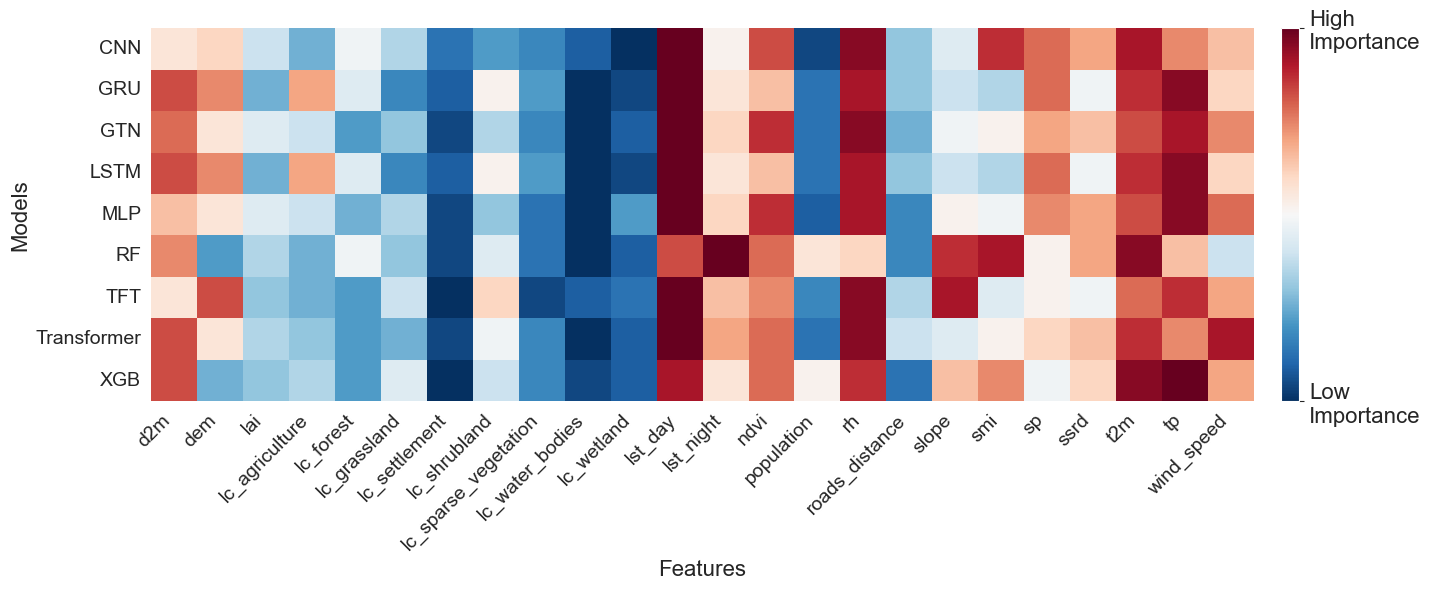

In [30]:
plot_rank_heatmap(df_reversed_shap, "SHAP")

In [13]:
def plot_shap_mean_std_barplot(df_ordered: pd.DataFrame, xai_method, feature_order=None):
    summary = df_ordered.groupby("Feature")["SHAP"].agg(["mean", "std"]).reset_index()

    if feature_order is not None:
        summary["Feature"] = pd.Categorical(summary["Feature"], categories=feature_order, ordered=True)
        summary = summary.sort_values("Feature")
    else:
        summary = summary.sort_values("mean", ascending=False)

    vmax = summary["mean"].max()
    vmin = summary["mean"].min()
    vcenter = summary["mean"].quantile(0.5)
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    color_values = [cm.RdBu_r(norm(val)) for val in summary["mean"]]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(
        summary["Feature"].astype(str),
        summary["mean"],
        yerr=summary["std"],
        capsize=5,
        color=color_values,
    )

    plt.ylabel(f"Mean |{xai_method}| Value", fontsize=14, fontweight='medium')
    plt.xticks(rotation=45, ha="right", fontsize=12, fontweight='medium')
    plt.yticks(fontsize=14)
    plt.title("")
    plt.tight_layout()

    plt.savefig(
        f'/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Paper Revision/mean_std_barplot_{xai_method}.png',
        format='png',
        dpi=300
    )
    plt.show()

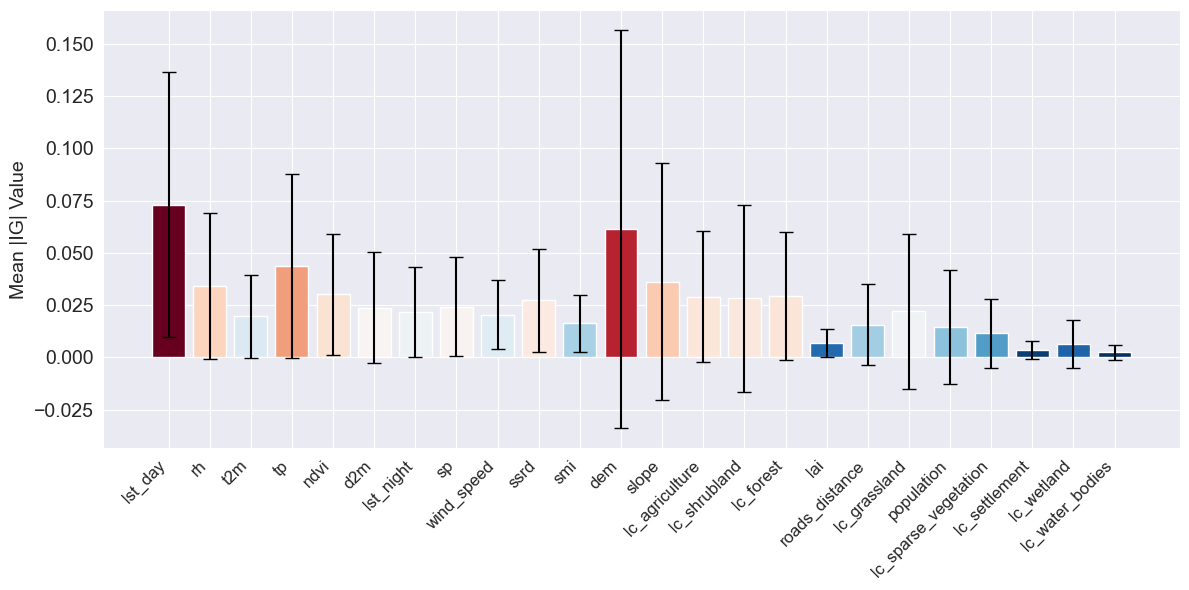

In [60]:
feature_order = [
    "lst_day", "rh", "t2m", "tp", "ndvi", "d2m", "lst_night", "sp",
    "wind_speed", "ssrd", "smi", "dem", "slope", "lc_agriculture",
    "lc_shrubland", "lc_forest", "lai", "roads_distance", "lc_grassland",
    "population", "lc_sparse_vegetation", "lc_settlement", "lc_wetland",
    "lc_water_bodies"
]

plot_shap_mean_std_barplot(df_ig_ordered, xai_method="IG", feature_order=feature_order)

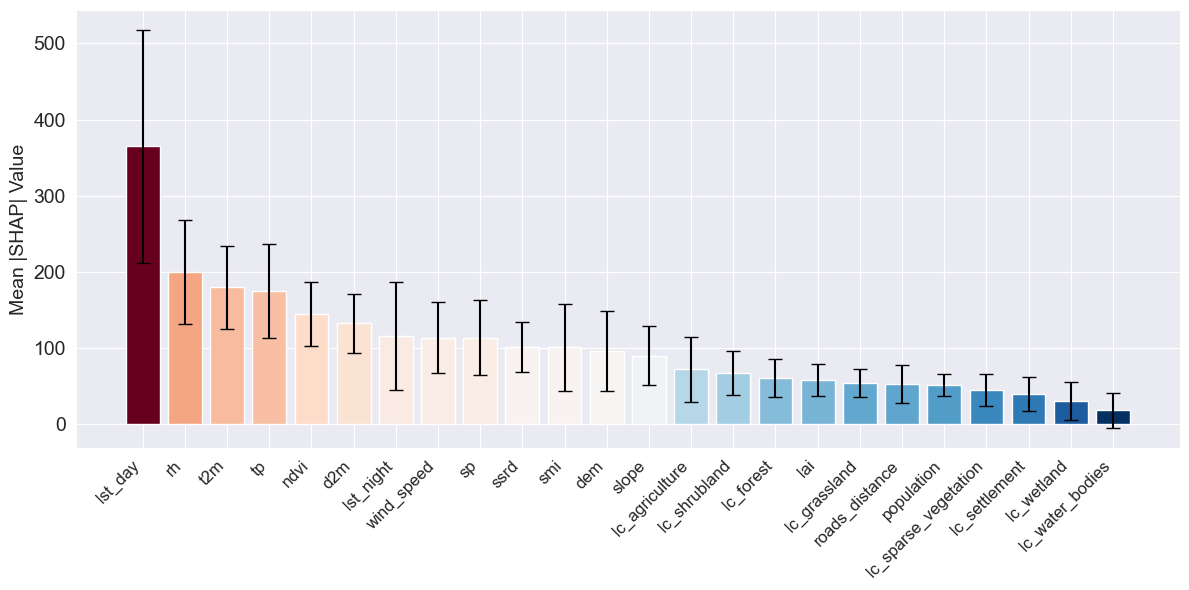

In [31]:
plot_shap_mean_std_barplot(df_ordered, "SHAP")

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd

def plot_shap_mean_std_barplot_transparent(df_ordered: pd.DataFrame, xai_method):
    summary = df_ordered.groupby("Feature")["SHAP"].agg(["mean", "std"]).reset_index()
    summary = summary.sort_values("mean", ascending=False)

    vmax = summary["mean"].max()
    vmin = summary["mean"].min()
    vcenter = summary["mean"].quantile(0.5)

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    color_values = [cm.RdBu_r(norm(val)) for val in summary["mean"]]

    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(
        summary["Feature"],
        summary["mean"],
        yerr=summary["std"],
        capsize=5,
        color=color_values,
    )


    ax.set_ylabel(f"Mean |{xai_method}| Value", fontsize=14, fontweight='medium', color='black')
    ax.set_xlabel("")  # kein Label für x-Achse notwendig
    ax.set_xticks(range(len(summary["Feature"])))
    ax.set_xticklabels(summary["Feature"], rotation=45, ha="right", fontsize=14, fontweight='medium', color='black')
    ax.tick_params(axis='y', colors='black', labelsize=14)

    ax.set_title("")


    fig.patch.set_alpha(0.0)   # Figure-Hintergrund
    ax.patch.set_alpha(0.0)    # Achsen-Hintergrund

    plt.tight_layout()
    plt.savefig(f'/Users/paulinebecker/Library/Mobile Documents/com~apple~CloudDocs/Uni/Wirtschaftsinformatik KIT/Semester6/Bachlorarbeit/Graphics/Results/Paper Revision/mean_std_barplot_{xai_method}.png', format='png', dpi=300)
    plt.show()



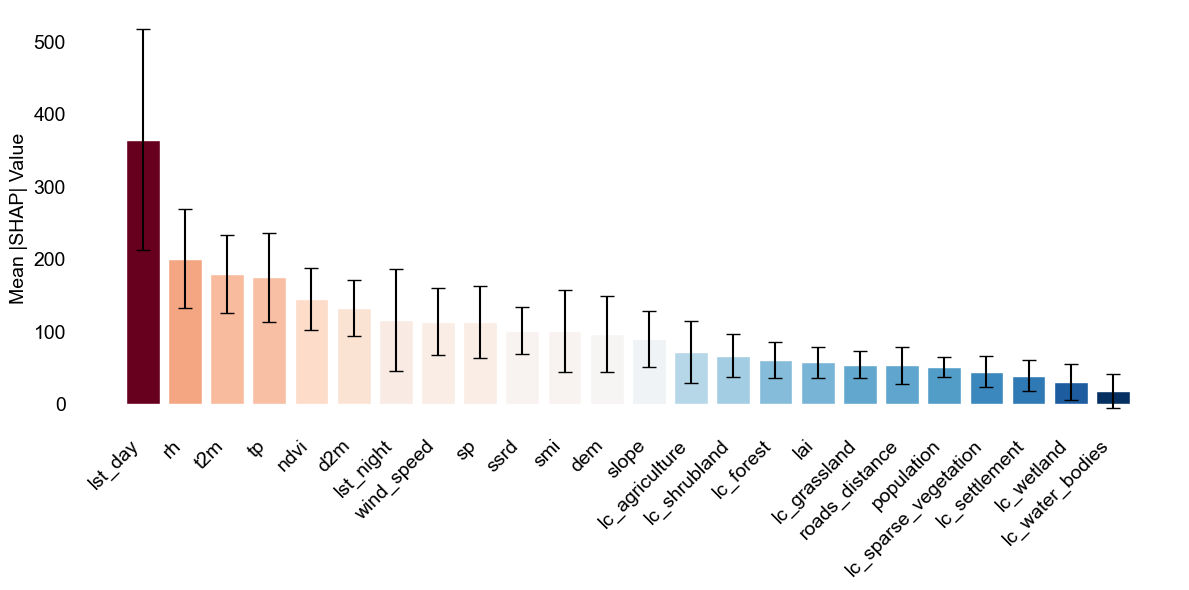

In [16]:
plot_shap_mean_std_barplot_transparent(df_ordered, "SHAP")

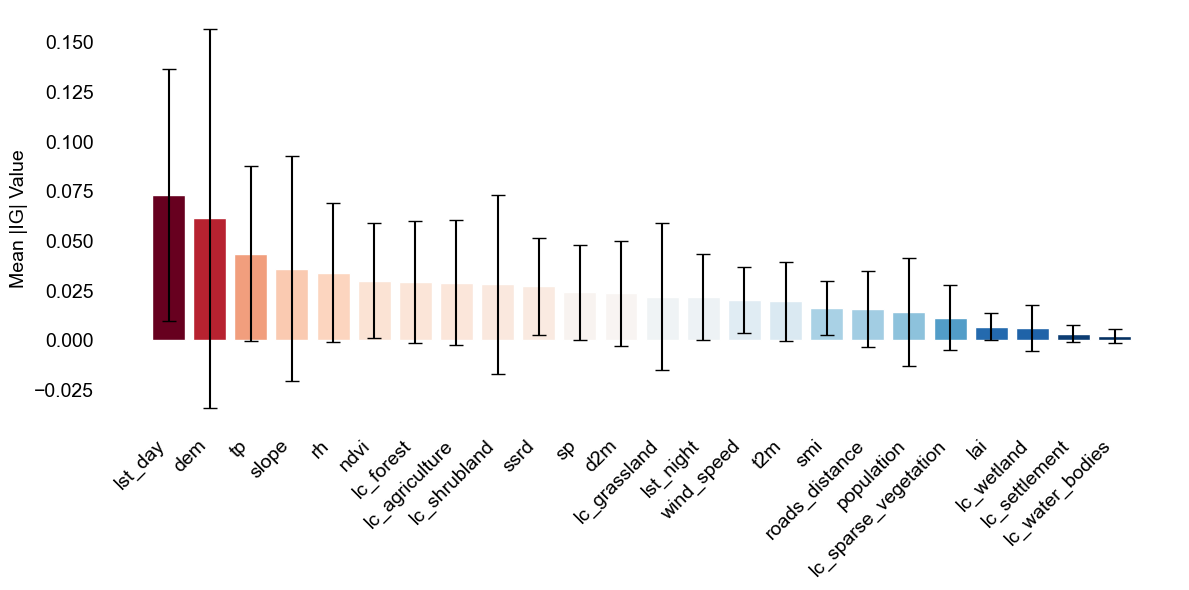

In [51]:
plot_shap_mean_std_barplot_transparent(df_ig_ordered, "IG")

In [59]:
def plot_feature_rank_barplot(df_ordered: pd.DataFrame):
    summary = df_ordered.groupby("Feature")["Rank"].agg(["mean", "std"]).reset_index()
    summary.columns = ["Feature", "MeanRank", "StdRank"]


    summary = summary.sort_values("MeanRank", ascending=True)

    plt.figure(figsize=(14, 6))
    bars = plt.bar(
        summary["Feature"],
        summary["MeanRank"],
        yerr=summary["StdRank"],
        capsize=5,
        color=plt.cm.Paired.colors
    )

    plt.ylabel("Mean Feature Rank", fontsize=14, fontweight='medium')
    plt.xticks(rotation=45, ha="right", fontsize=12, fontweight='medium')
    plt.yticks(fontsize=12)
    plt.title("Mean Feature Rankings for Wildfire Contribution Across Models", fontsize=14, fontweight='medium')
    plt.tight_layout()
    plt.show()


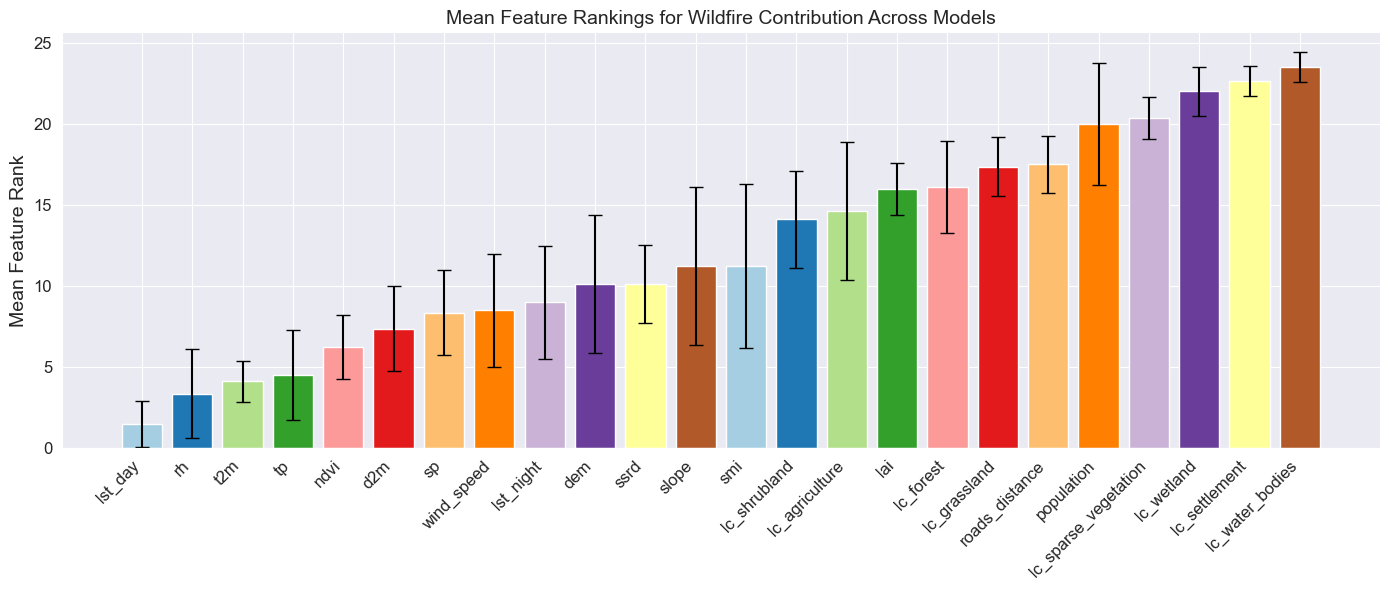

In [60]:
plot_feature_rank_barplot(df_ordered)

In [ ]:
for bar, rank in zip(bars, summary["MeanRank"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height - 2.5,
        f"{rank:.1f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=90,
        color="black"
    )